# Add costing and emissions calculations to process model

## ROK model code = M2

In [1]:
# simulation case specifications
model_code = 2
case_name = 'Bakken'
c_tax_rate = 4.5e-2 # $/kg CO2e

In [2]:
from idaes.core.util.model_statistics import degrees_of_freedom, large_residuals_set

# Import idaes model serializer to store initialized model
from idaes.core.util import model_serializer as ms

from pyomo.environ import (Constraint,
                           ConstraintList,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Set,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value,
                           minimize)

from src.unit_initialization import create_flowsheet, \
                                    define_models, \
                                    define_arcs, \
                                    set_unit_model_variables, \
                                    initialize_flowsheet, \
                                    set_scaling_factors,\
                                    update_model_after_initialization,\
                                    vapor_only_to_vapor_liquid_reformulate,\
                                    update_model_for_optimization, \
                                    unfix_DOFs_pre_optimization, \
                                    fix_DOFs_post_optimization

## Create flowsheet

In [3]:
m = create_flowsheet(model_code)

In [4]:
M_catalyst = 1167.003367 # kg

## Define equipment and connections

In [5]:
# define unit models
define_models(m, catalyst_mass = M_catalyst)
#define connections
define_arcs(m)

## Define inlet compositions

In [6]:
import pandas as pd

inlet_df = pd.read_csv('NGL_compositions.csv')

inlet_composition_dict = {}

for col in inlet_df.columns:
    if col == case_name:
        for i,r in inlet_df.iterrows():
            if r[col] == 0.0:
                inlet_composition_dict[r['Species']] = 1e-6
            else:
                inlet_composition_dict[r['Species']] = round(r[col],4)

inlet_flow_rate = 481.3888889

dehydro_conv_dict = {'ethane':0.3566,
                     'propane':0.6632,
                     'nbutane':0.5188}

## Define constraints and set-points for equipment

In [7]:
set_unit_model_variables(m, model_code=model_code, feed_flow_rate = inlet_flow_rate, 
                         feed_temp = 308.0, feed_pressure = 700000.0,
                         inlet_composition_dict = inlet_composition_dict,
                         dehydro_conv_dict = dehydro_conv_dict)

## Scale model components

In [8]:
if model_code == 2 or model_code == 3:
    set_scaling_factors(m,flow_mol_scaling_factor = 1e-2, inlet_composition_dict = inlet_composition_dict)
elif model_code == 4 or model_code == 5:
    set_scaling_factors(m,flow_mol_scaling_factor = 1e-3, inlet_composition_dict = inlet_composition_dict)
else:
    pass

## Sequence for initialization

In [9]:
init_file_name = "./initialization_files/CISTAR_unit_initialization_{}_M{}.json.gz".format(case_name, model_code)
ms.from_json(m, fname=init_file_name)

{'etime_load_file': 0.0613560676574707,
 'etime_read_dict': 0.18865108489990234,
 'etime_read_suffixes': 0.005452156066894531}

## Add post-initialization constraints

In [10]:
update_model_after_initialization(m)
vapor_only_to_vapor_liquid_reformulate(m.fs.T102)
vapor_only_to_vapor_liquid_reformulate(m.fs.T102)

Liquid phase flow is zero. Translator block fs.T102 liquid phase composition equations are being modified...

Degenerate constraints removed and liquid phase composition values set to 1e-8

Translator block fs.T102 liquid phase composition equations already modified, no degenerate constraints remaining.



In [11]:
init_file_name = "./initialization_files/CISTAR_solve_constrained_{}_M{}_purge_{}.json.gz".format(case_name, model_code,round(m.fs.S102.split_fraction[0, "purge"](),3))
ms.from_json(m, fname=init_file_name)

{'etime_load_file': 0.08684492111206055,
 'etime_read_dict': 0.1892080307006836,
 'etime_read_suffixes': 0.006987810134887695}

# Costing

In [12]:
from src.emissions_calculations import calc_lhv_values, calculate_stream_energies, calculate_emissions, create_ghg_objective
from src.costing_function import add_costing,calculate_costs_for_objective
from src.utility_minimization_1d import (
    min_utility,
    PinchDataClass,
    heat_ex_data,
    gen_curves,
    print_HX_results,
    generate_curves,
    heat_data,
    pinch_calc,
    return_data
)

## Equipment costing

In [13]:
add_costing(m)

## Heat integration

In [14]:
### Heat Exchangers and reactors
min_utility(
    m.fs, [m.fs.H101, m.fs.H103, m.fs.R101], [m.fs.H102, m.fs.H104, m.fs.H105, m.fs.H106, m.fs.R102], 10.0
)
m.fs.Qs.fix()

## Emissions calculations

In [15]:
calc_lhv_values(m,case_name,'./LHV.xlsx','NGL_compositions.csv','NGL_fraction.csv')
calculate_stream_energies(m)
calculate_emissions(m,case_name,'emissions_factor_by_region.csv')
create_ghg_objective(m)
calculate_costs_for_objective(m,c_tax_flag=True, c_tax_val = c_tax_rate)

In [16]:
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6,
                  'bound_push': 1e-8,
                      'max_iter': 500,
#                   'halt_on_ampl_error':'yes'
                 }
# solve_status = solver.solve(m, tee=True)
solve_status = solver.solve(m, tee=True)

# Save and display results
ms.to_json(m, fname="./initialization_files/CISTAR_solve_with_costing_{}_C_tax_{}_M{}_purge_{}.json.gz".format(case_name,m.fs.c_tax_rate(), model_code,round(m.fs.S102.split_fraction[0, "purge"](),3)))

The initial DOF is 0
Ipopt 3.13.2: tol=1e-06
bound_push=1e-08
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran code

## Save and display results

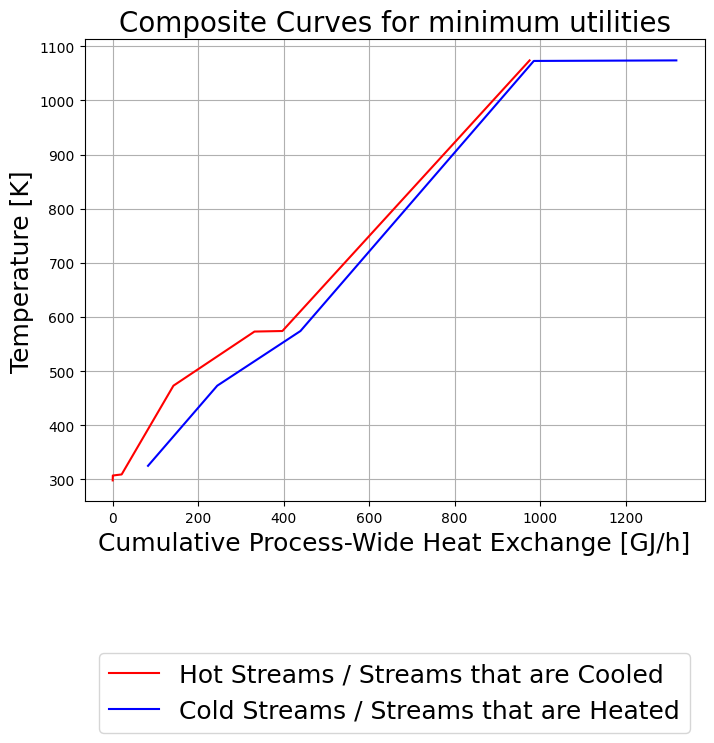

In [17]:
CDs = heat_ex_data(m.fs, [m.fs.H101, m.fs.H103, m.fs.R101], [m.fs.H102, m.fs.H104, m.fs.H105, m.fs.H106, m.fs.R102])
generate_curves(CDs)

In [18]:
print_HX_results(m.fs, [m.fs.H101, m.fs.R101, m.fs.H102, m.fs.H103, m.fs.R102, m.fs.H104, m.fs.H105, m.fs.H106])

Heat Exchanger Summary: 
Heat exchanger:  fs.H101
Inlet T:      324.943 K
Outlet T:     1073.000 K
Q :            227671656.080 kg*m**2/s**3
Heat exchanger:  fs.R101
Inlet T:      1073.000 K
Outlet T:     1073.000 K
Q :            92331093.753 kg*m**2/s**3
Heat exchanger:  fs.H102
Inlet T:      1073.000 K
Outlet T:     473.000 K
Q :           -193121293.657 kg*m**2/s**3
Heat exchanger:  fs.H103
Inlet T:      473.000 K
Outlet T:     573.000 K
Q :            23364400.824 kg*m**2/s**3
Heat exchanger:  fs.R102
Inlet T:      573.000 K
Outlet T:     573.000 K
Q :           -17624147.069 (kg*m/s**3)*m
Heat exchanger:  fs.H104
Inlet T:      573.000 K
Outlet T:     308.000 K
Q :           -54602854.954 kg*m**2/s**3
Heat exchanger:  fs.H105
Inlet T:      308.000 K
Outlet T:     307.009 K
Q :           -5533336.271 kg*m**2/s**3
Heat exchanger:  fs.H106
Inlet T:      305.058 K
Outlet T:     298.000 K
Q :           -66185.061 kg*m**2/s**3


In [19]:
m.fs.Qs()

343.333349789008

In [20]:
m.fs.Qw()

82.62374866579948

In [21]:
m.fs.downstream_emissions() # kg CO2e/GJ fuel

9.226400828333643

In [22]:
m.fs.M101.report()
m.fs.H101.report()
m.fs.R101.report()
m.fs.H102.report()
m.fs.S101.report()
m.fs.E101.report()
m.fs.H103.report()
m.fs.R102.report()
m.fs.H104.report()
m.fs.T101.report()
m.fs.H105.report()
m.fs.F101.report()
m.fs.H106.report()
m.fs.F102.report()
m.fs.T102.report()
m.fs.T103.report()
m.fs.C101.report()
m.fs.M102.report()
m.fs.S102.report()
m.fs.C102.report()


Unit : fs.M101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                     Units         feed      recycle    Outlet  
    Total Molar Flowrate          mole / second     481.39     2256.0     2737.4
    Total Mole Fraction hydrogen  dimensionless 1.0000e-06    0.12085   0.099599
    Total Mole Fraction methane   dimensionless   0.081100    0.18395    0.16586
    Total Mole Fraction ethane    dimensionless    0.46920    0.14208    0.19960
    Total Mole Fraction propane   dimensionless    0.30920   0.032118   0.080844
    Total Mole Fraction nbutane   dimensionless   0.078400   0.012944   0.024454
    Total Mole Fraction ibutane   dimensionless   0.026500   0.078690   0.069512
    Total Mole Fraction pentane   dimensionless   0.025800   0.015688   0.017466
    Total Mole Fraction hexane    dimensionless  0.0061000  0.0012036  0.0020647
  


Unit : fs.R102                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key  : Value  : Units      : Fixed : Bounds
    Area : 1.6208 : meter ** 2 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                     Units         Inlet     Outlet  
    Total Molar Flowrate          mole / second     2639.3     2439.4
    Total Mole Fraction hydrogen  dimensionless    0.10435    0.11290
    Total Mole Fraction methane   dimensionless    0.15883    0.17184
    Total Mole Fraction ethane    dimensionless    0.12298    0.13305
    Total Mole Fraction propane   dimensionless   0.028241   0.030555
    Total Mole Fraction nbutane   dimensionless   0.012205   0.013205
    Total Mole Fraction ibutane   dimensionless   0.072097   0.078004
    Total Mole Fraction p


Unit : fs.H106                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key       : Value   : Units : Fixed : Bounds
    Heat Duty : -66185. :  watt : False : (None, 0.0)

------------------------------------------------------------------------------------
    Stream Table
                                           Units         Inlet     Outlet  
    Molar Flowrate ('Liq', 'ethane')    mole / second     3.3298     1.7604
    Molar Flowrate ('Liq', 'propane')   mole / second     2.4794     1.9789
    Molar Flowrate ('Liq', 'nbutane')   mole / second     3.3240     3.1035
    Molar Flowrate ('Liq', 'ibutane')   mole / second     14.506     13.177
    Molar Flowrate ('Liq', 'pentane')   mole / second     12.817     12.553
    Molar Flowrate ('Liq', 'hexane')    mole / second     2.9631     2.9437
    Molar Flowrate ('Liq', 'heptane')   mole / secon